# How Network Changes with Aging
- We expect volume atrophy with normal aging and faster volume atrophy with those that experienced a TIA/minor stroke. [Paper](https://www.sciencedirect.com/science/article/pii/S2666245021000167)
- The question is how do edge weights in the network change with aging?
    - Since volume is decreasing, the number of fibre counts should decrease normally.
    - For those who experienced a TIA/minor stroke, does this specifically target/affect fibre count? Or is it primarily impacting nodal volume rather than edge weights.
- Important note: When we say aging, we do not mean each individual's age. We want to see changes within an individual
rather than across individuals. So we're not plotting anything against the age of a subject. Interpret the change in years
between BL and Y5 (5 years) as "aging".

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import importlib
import sys
import os
import scipy.stats
import pickle as pkl
import matplotlib.pyplot as plt
print(sys.version)

import Towlson_group_code.data_io as myFunc
importlib.reload(myFunc)

import PREVENT_functions as prev_fct
importlib.reload(prev_fct)

PICKLE_PATH = '../../PREVENT_Study/pickles/'
FIGURE_PATH = '../../PREVENT_Study/figures/'
DUMP_PATH = '../../PREVENT_Study/dump/'
TIMES = ['bl', 'y1', 'y3', 'y5']
metadata, node_list = prev_fct.load_meta_data()
print(len(node_list))

3.8.12 (default, Mar  1 2023, 16:37:51) 
[Clang 13.1.6 (clang-1316.0.21.2.5)]
150


# Volume Atrophy
- Compare volume atrophy rates of Controls vs TIAs. Confirm findings in [Paper](https://www.sciencedirect.com/science/article/pii/S2666245021000167).
- [X] Volume used here has been TIV normalized.

In [2]:
individual_data = myFunc.load_from_pickle(PICKLE_PATH, 'Non_Normalized_Connectomes.pkl')

# print(individual_data['HCbl']['377'].edges(data=True))

In [27]:
def get_avg_volume_whole_brain(pid, vol_df):
    if sum(vol_df.loc[int(pid)]) > 1:
        return -1
    return sum(vol_df.loc[int(pid)])


def get_avg_volume(pid, vol_df, rois):
    if sum(vol_df.loc[int(pid)][rois]) > 1:
        return -1
    return sum(vol_df.loc[int(pid)][rois])


def get_volume(pid, vol_df, roi):
    rois_found = []
    for nname in node_list:
        if roi.lower() in nname.lower():
            rois_found.append(nname)
    # if sum(vol_df.loc[int(pid)][rois_found]) > 1:
    #     return -1, []
    return sum(vol_df.loc[int(pid)][rois_found]), rois_found


def get_roi_nf(G, roi):
    nf_t = 0
    edges = nx.get_edge_attributes(G, "weight")
    for edge, w in edges.items():
        if (roi.lower() in edge[0].lower()) or (roi.lower() in edge[1].lower()):
            nf_t += w
    return nf_t


def get_total_nf(G):
    edges = nx.get_edge_attributes(G, "weight")
    return sum(edges.values())

In [35]:
def get_vol_nf_df(roi):
    ids = []
    time = []
    age = []
    vol = []
    diagnosis = []
    nf_c = []
    for k in individual_data.keys():
        if len(k) == 4:
            ptype = k[:2]
            t = k[2:]
        else:
            ptype = k[0]
            t = k[1:]
        vol_df = myFunc.load_from_pickle(PICKLE_PATH, f'{t}_volume.pkl')
        for pid, G in individual_data[k].items():
            tv, rois_l = get_volume(pid, vol_df, roi)
            # tv = get_avg_volume_whole_brain(pid, vol_df)
            # if tv == -1:
                # print(t)
                # continue
            if len(rois_l) == 0:
                print(f"Found no rois associated with {roi}. Weird?", rois_l)
                continue
            diagnosis.append(ptype)
            ids.append(pid)
            time.append(t)
            try:
                age.append(metadata.loc[pid]['Age'])
            except KeyError:
                print("Missing ", pid, ptype)
                continue
            vol.append(tv)
            # ----- NF stuff -----
            # nf_c.append(get_total_nf(G))
            nf_c.append(get_roi_nf(G, roi))
    return pd.DataFrame(data = {'ID': ids, 'Age': age, 'Time': time, 'C/T': diagnosis, 'vol': vol, 'nf': nf_c})

# vol_df = myFunc.load_from_pickle(PICKLE_PATH, f'bl_volume.pkl')
# G = individual_data['Pbl']['002']
# tv, rois_l = get_volume('002', vol_df, 'hippocampus')
# print(tv, rois_l)

# Volume Atrophy with Aging
The volume atrophy was measured over a 3 year period and assuming a linear rate of change, a yearly atrophy rate
was compared between Control and TIA group. We'll make a similar box plot figure as found in the paper except we will
use a 5 year period since we don't have enough 3 year data due to COVID disruptions.
Let's see what is our yearly atrophy rate is in comparison.
- [X] Adjust code to work for 5 years, 3 years, 1 year, etc.
- [X] Create the same change but instead of volume atrophy, what about edge weight (nf) changes?
- [ ] Is the nf changes faster than Control?

In [40]:
from scipy.stats import mannwhitneyu

def boxplot_atrophy_rate(plot_df, t1, t2, yrs, metric, title):
    plt.figure()
    data_y3 = plot_df[(plot_df['Time']==t2)][['ID', metric]]
    data_bl = plot_df[(plot_df['Time']==t1)][['ID', metric, 'C/T']]
    data_y3_bl = data_bl.set_index(['ID']).join(data_y3.set_index(['ID']), on='ID', lsuffix='_1', rsuffix='_2')
    data_y3_bl = data_y3_bl.dropna()
    data_y3_bl['Annual Atrophy'] = (data_y3_bl[f'{metric}_2'] - data_y3_bl[f'{metric}_1'])/yrs
    # print("HC", len(data_y3_bl[data_y3_bl['C/T']=='HC']))
    # print("P", len(data_y3_bl[data_y3_bl['C/T']=='P']))

    # --- Mann Whitney test ----
    _, p = mannwhitneyu(data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy'], data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'], method='asymptotic', alternative="two-sided")

    hc_mean = data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'].mean()
    hc_std = data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'].std()
    p_mean = data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy'].mean()
    p_std = data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy'].std()

    bp = plt.boxplot([data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'],
                 data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy']])
    plt.xticks([1, 2], ['HC', 'P'])
    plt.title(f'{title.capitalize()} Annual Atrophy over {yrs} yrs (p = {p:0.3f}) ')
    plt.ylabel(f"{metric}/years")
    plt.legend([bp["boxes"][0], bp["boxes"][1]],
               [f"HC (mean +-"
                f" SD): {hc_mean:0.2f} +- {hc_std:0.3f}", f"TIA (mean +- SD): {p_mean:0.2f} +- {p_std:0.3f}"],
               loc='upper center', bbox_to_anchor=(0.5, -0.08))
    plt.savefig(f'../../PREVENT_study/figures/network w aging/search/{title.capitalize()} Atrophy {t2}.png', dpi=300, edgecolor='none', bbox_inches='tight')
    plt.show()

- Boxplot Volume atrophy with Aging
- Boxplot Edge weight (nf) change with Aging

In [70]:
roi = 'hippocampus'
plot_df = get_vol_nf_df(roi)

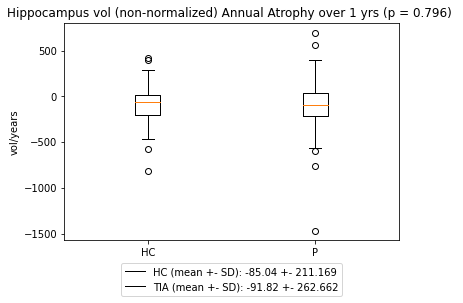

In [42]:
# boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'nf', f"{roi} nf")
boxplot_atrophy_rate(plot_df, 'bl', 'y1', 1, 'vol', f"{roi} Vol (Non-normalized)")

- Repeat the vol and nf boxplots above, but for each node in the node list; does any node have a significant
p value?
    - Don't see any significant nf changes after Bonferroni correction.

Left-Thalamus
Left-Caudate
Left-Putamen
Left-Hippocampus
Left-Amygdala
Left-Accumbens-area
Right-Thalamus
Right-Caudate
Right-Putamen
Right-Hippocampus
Right-Amygdala
Right-Accumbens-area
ctx_lh_G_and_S_frontomargin
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

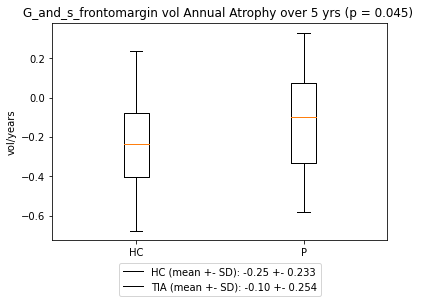

ctx_lh_G_and_S_occipital_inf
ctx_lh_G_and_S_paracentral
ctx_lh_G_and_S_subcentral
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

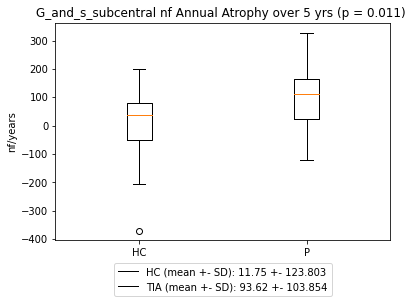

ctx_lh_G_and_S_transv_frontopol
ctx_lh_G_and_S_cingul-Ant
ctx_lh_G_and_S_cingul-Mid-Ant
ctx_lh_G_and_S_cingul-Mid-Post
ctx_lh_G_cingul-Post-dorsal
ctx_lh_G_cingul-Post-ventral
ctx_lh_G_cuneus
ctx_lh_G_front_inf-Opercular
ctx_lh_G_front_inf-Triangul
ctx_lh_G_front_middle
ctx_lh_G_front_sup


/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_87472/1107317358.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


ctx_lh_G_occipital_middle
ctx_lh_G_occipital_sup
ctx_lh_G_oc-temp_lat-fusifor
ctx_lh_G_oc-temp_med-Lingual
ctx_lh_G_oc-temp_med-Parahip
ctx_lh_G_orbital
ctx_lh_G_pariet_inf-Angular
ctx_lh_G_pariet_inf-Supramar
ctx_lh_G_parietal_sup
ctx_lh_G_postcentral
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

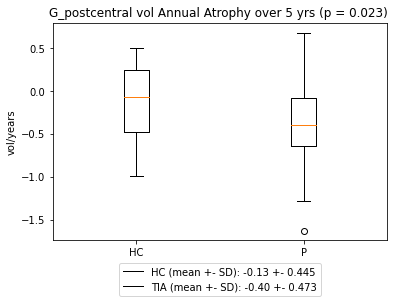

ctx_lh_G_precentral
ctx_lh_G_precuneus
ctx_lh_G_rectus
ctx_lh_G_temp_sup-G_T_transv
ctx_lh_G_temp_sup-Lateral
ctx_lh_G_temp_sup-Plan_polar
ctx_lh_G_temp_sup-Plan_tempo
ctx_lh_G_temporal_inf
ctx_lh_G_temporal_middle
ctx_lh_Lat_Fis-ant-Horizont


/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_87472/1107317358.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


ctx_lh_Lat_Fis-ant-Vertical
ctx_lh_Lat_Fis-post
ctx_lh_Pole_occipital
ctx_lh_Pole_temporal
ctx_lh_S_calcarine
ctx_lh_S_central
ctx_lh_S_cingul-Marginalis
ctx_lh_S_circular_insula_ant
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

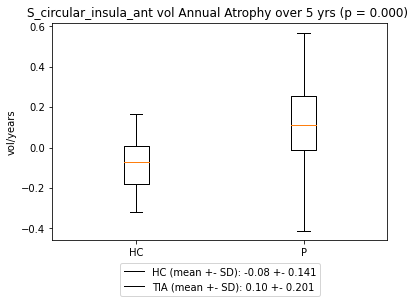

ctx_lh_S_circular_insula_inf
ctx_lh_S_circular_insula_sup
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

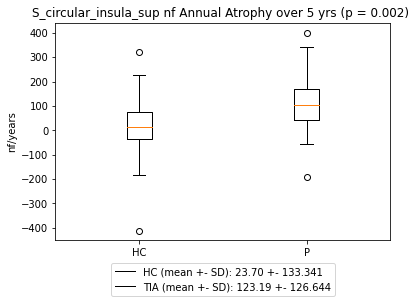

ctx_lh_S_collat_transv_ant
ctx_lh_S_collat_transv_post
ctx_lh_S_front_inf
ctx_lh_S_front_middle
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

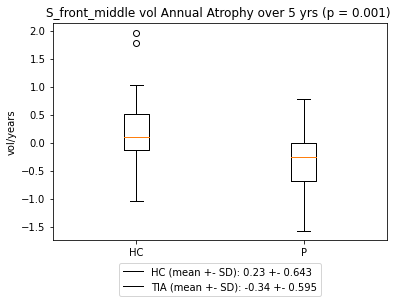

ctx_lh_S_front_sup
ctx_lh_S_intrapariet_and_P_trans
ctx_lh_S_oc_middle_and_Lunatus
ctx_lh_S_oc_sup_and_transversal
ctx_lh_S_occipital_ant
ctx_lh_S_oc-temp_lat
ctx_lh_S_oc-temp_med_and_Lingual
ctx_lh_S_orbital_lateral
ctx_lh_S_orbital_med-olfact
ctx_lh_S_orbital-H_Shaped


/var/folders/4y/c5k89vrd43d510t1vrpm1t180000gn/T/ipykernel_87472/1107317358.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


ctx_lh_S_parieto_occipital
ctx_lh_S_pericallosal
ctx_lh_S_postcentral
Found something!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

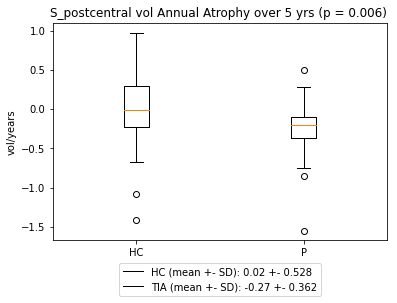

ctx_lh_S_precentral-inf-part
ctx_lh_S_precentral-sup-part
ctx_lh_S_suborbital
ctx_lh_S_subparietal
ctx_lh_S_temporal_inf
ctx_lh_S_temporal_sup
ctx_lh_S_temporal_transverse
ctx_rh_G_and_S_frontomargin
ctx_rh_G_and_S_occipital_inf
ctx_rh_G_and_S_paracentral
ctx_rh_G_and_S_subcentral
ctx_rh_G_and_S_transv_frontopol
ctx_rh_G_and_S_cingul-Ant
ctx_rh_G_and_S_cingul-Mid-Ant
ctx_rh_G_and_S_cingul-Mid-Post
ctx_rh_G_cingul-Post-dorsal
ctx_rh_G_cingul-Post-ventral
ctx_rh_G_cuneus
ctx_rh_G_front_inf-Opercular
ctx_rh_G_front_inf-Triangul
ctx_rh_G_front_middle
ctx_rh_G_front_sup
ctx_rh_G_occipital_middle
ctx_rh_G_occipital_sup
ctx_rh_G_oc-temp_lat-fusifor
ctx_rh_G_oc-temp_med-Lingual
ctx_rh_G_oc-temp_med-Parahip
ctx_rh_G_orbital
ctx_rh_G_pariet_inf-Angular
ctx_rh_G_pariet_inf-Supramar
ctx_rh_G_parietal_sup
ctx_rh_G_postcentral
ctx_rh_G_precentral
ctx_rh_G_precuneus
ctx_rh_G_rectus
ctx_rh_G_temp_sup-G_T_transv
ctx_rh_G_temp_sup-Lateral
ctx_rh_G_temp_sup-Plan_polar
ctx_rh_G_temp_sup-Plan_tempo
ctx_rh_

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [230]:
# Used for tracking region names since we won't separately test left vs right region.
searched_set = set()
for node_name in node_list:
    words = node_name.split("_")
    if len(words) >= 3:
        roi = node_name[7:].lower()
        if roi not in searched_set:
            searched_set.add(roi)
            plot_df = get_vol_nf_df(roi)
            boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'vol', f"{roi} vol")
            boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'nf', f"{roi} nf")
    else:
        words = node_name.split("-")
        if (len(words) == 2) and (words[1].lower() not in searched_set):
            roi = words[1].lower()
            searched_set.add(roi)
            plot_df = get_vol_nf_df(roi)
            boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'vol', f"{roi} vol")
            boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'nf', f"{roi} nf")
print(f"Searched through {len(searched_set)} nodes.")

# Individual Tracking
Since TIA and stroke like diseases can occur at any location in the brain, two individuals who both have experienced a
stroke can have very different results in their brain impact. Averaging this kind of study is not a good method. In addition
if there is a problem in the automation pipeline for processing image into connectome data, we can use this plot to highlight
strange behaving data and go back and individually check those scans.
- [X] track Hippocampus volume change vs Hippocampus nf change for participants that have at least 2 points of follow-up.

In [51]:
def individual_scatter(df, metric, title, save_flag=False):
    aged = {'bl': 0, 'y1': 1, 'y3': 3, 'y5': 5}
    color_palette = {'HC': 'tab:blue', 'P': 'tab:orange'}
    ls = {0: 'solid', 1: 'dashed', 2: 'dotted', 3: 'dashdot'}
    # Go through everyone who has y5 data and plot
    fig = plt.figure(figsize=(8, 10), dpi=300)
    y5_pop = df[df['Time']=='y5'][['ID', 'C/T', 'Age']]
    df = df.set_index(['ID'])
    for i, me in enumerate(metric):
        skips = 0
        j = 0
        print(ls[i], me)
        for idx, row in y5_pop.iterrows():
            id = row['ID']
            ptype = row['C/T']
            data_list = []
            bl_age = row['Age']
            if isinstance(df.loc[id], pd.Series):
                skips += 1
                continue
            for _, row in df.loc[id].iterrows():
                data_list.append((bl_age + aged[row['Time']], row[me]))
            data_list = sorted(data_list, key = lambda x: x[0])
            norm = data_list[0][1]
            # norm = 1
            i_x = [x for x,_ in data_list]
            i_y = [(y/norm)+j*0.7 for _, y in data_list]
            plt.plot(i_x, i_y, linestyle=ls[i], marker='.', color=color_palette[ptype])
            # Check if from Y5 - BL the nf was increasing. If it is, show ID.
            if me == 'nf':
                y5_y = i_y[-1]
                bl_y = i_y[0]
                if y5_y - bl_y > 0:
                    plt.text(i_x[0]-1, bl_y+0.2, id, fontsize=8)
            j += 1
        print(f"Skipped {skips} individuals")
    plt.xlabel("Aging")
    plt.ylabel("Normalized Volume/Weight")
    plt.title(title)
    plt.savefig(f'../../PREVENT_study/figures/'+title+'.png', dpi=300, facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')
    plt.show()

solid vol
Skipped 0 individuals
dashed nf
Skipped 0 individuals


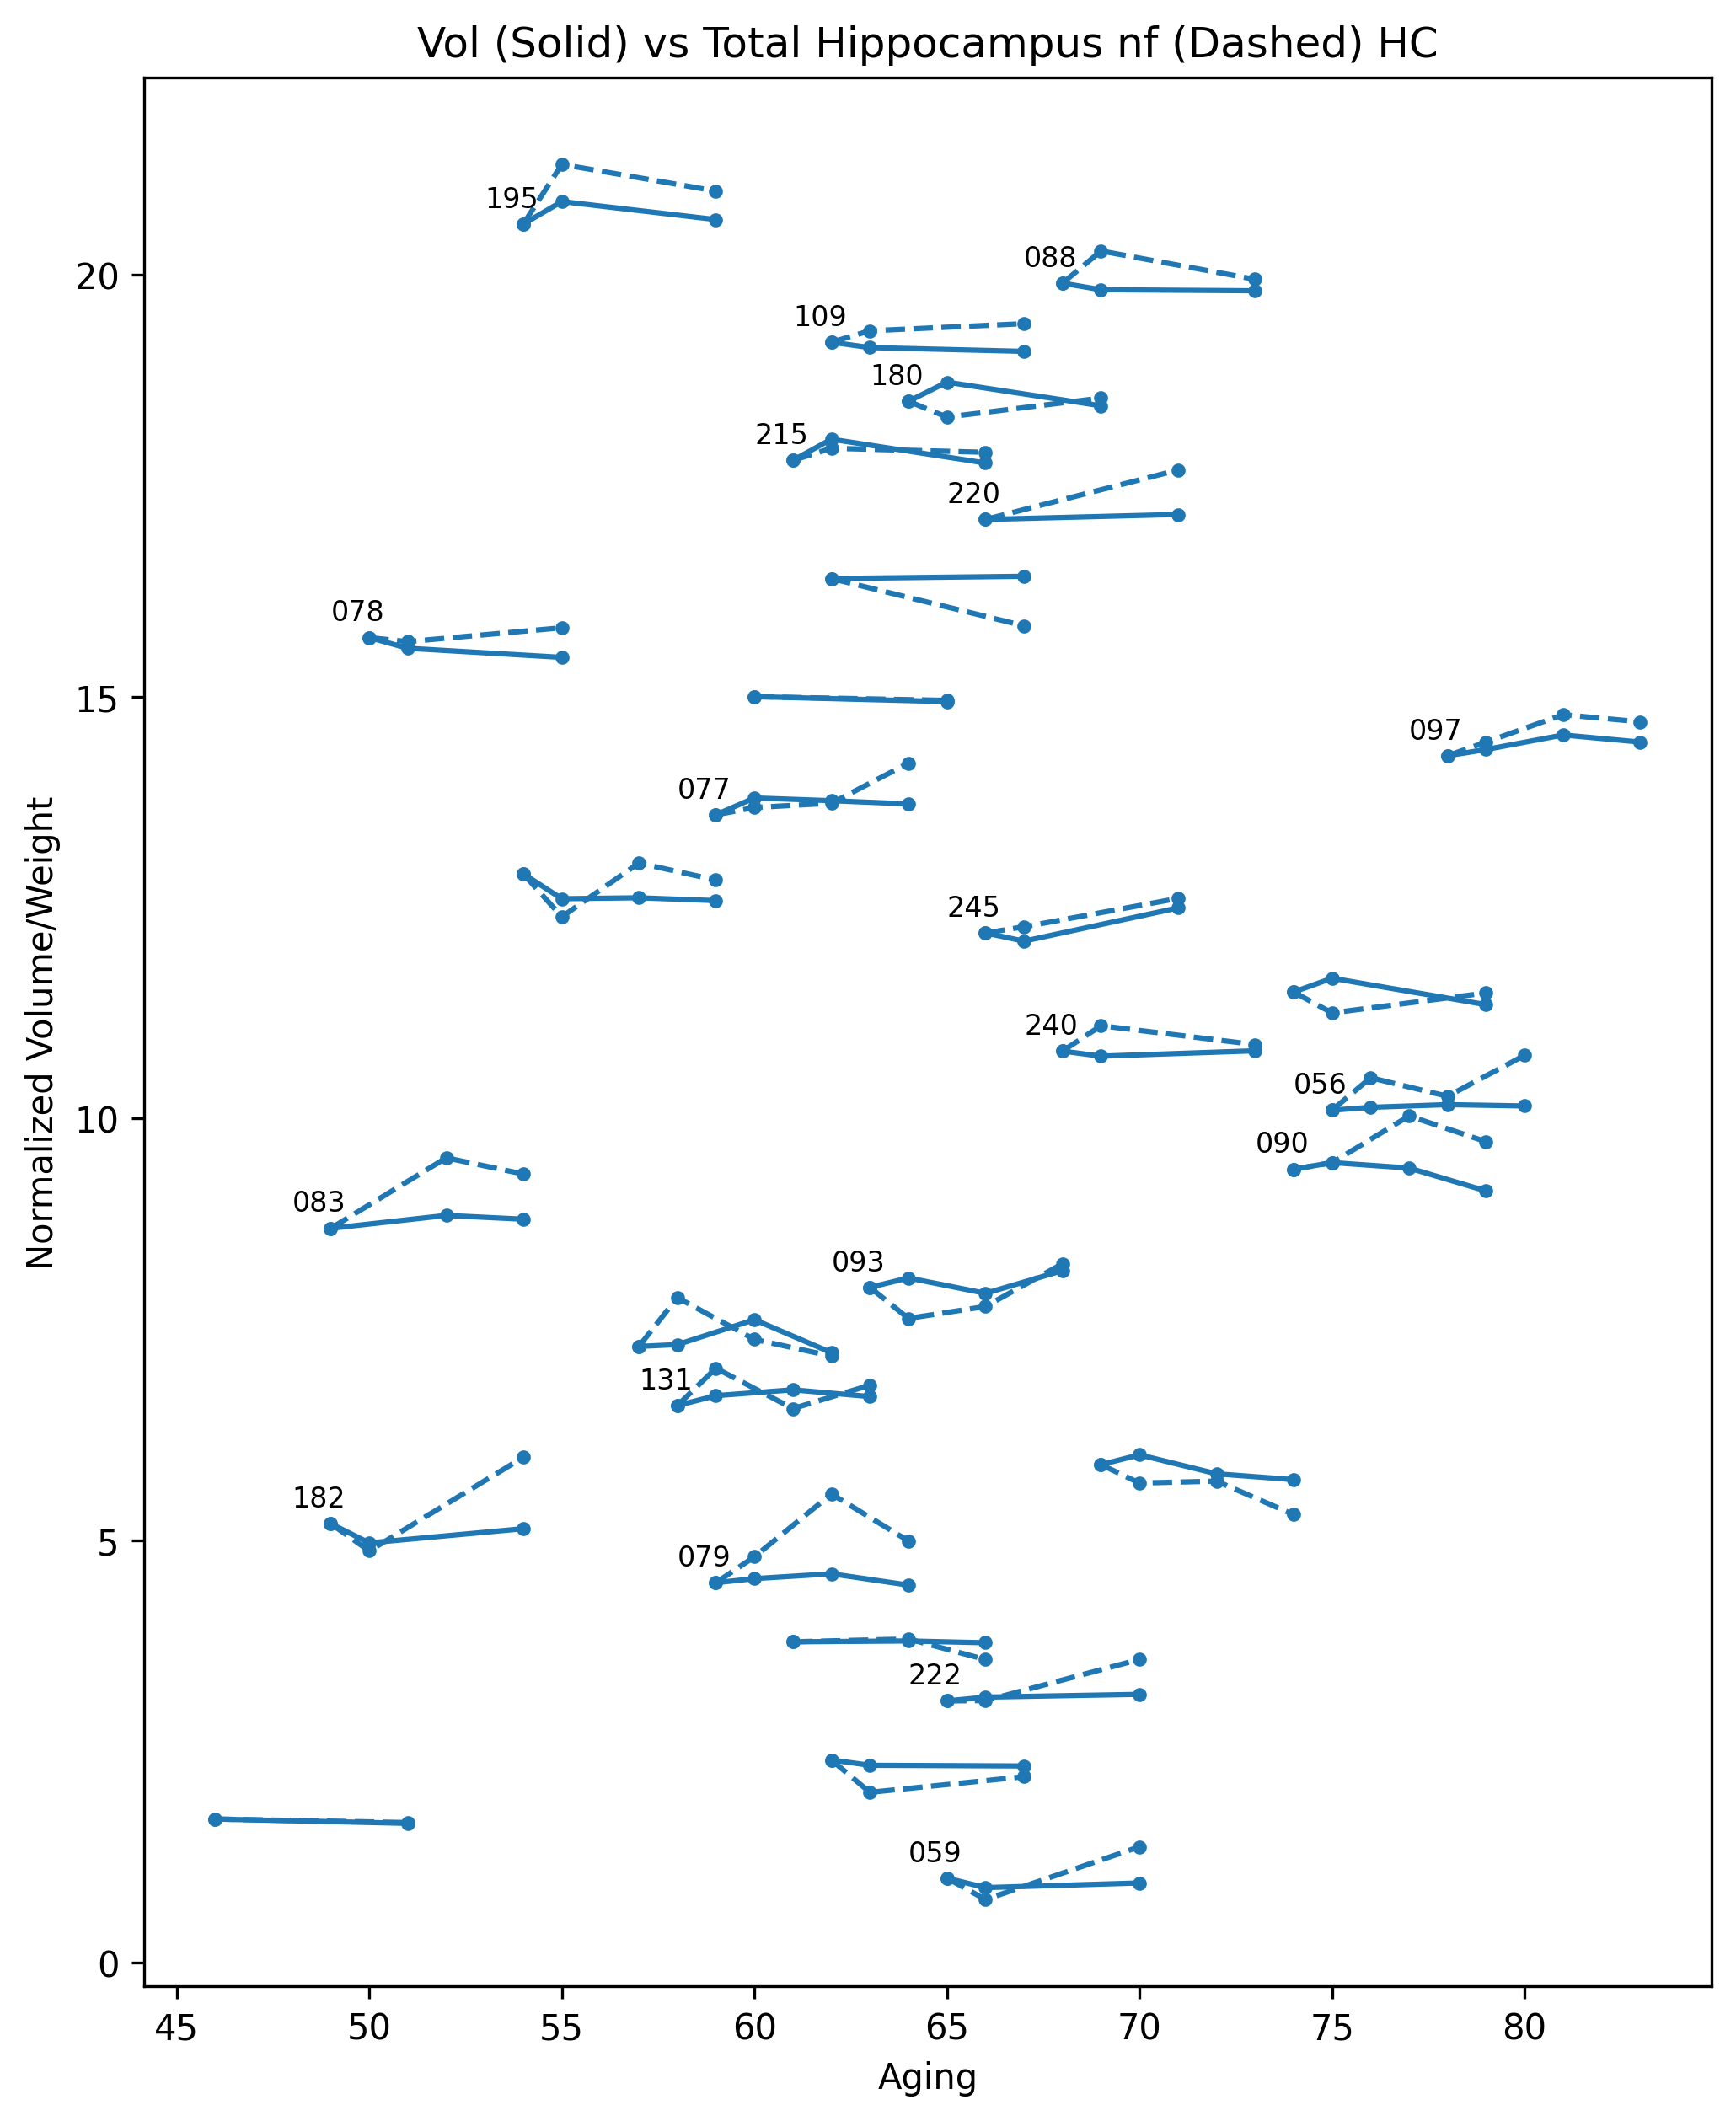

solid vol
Skipped 0 individuals
dashed nf
Skipped 0 individuals


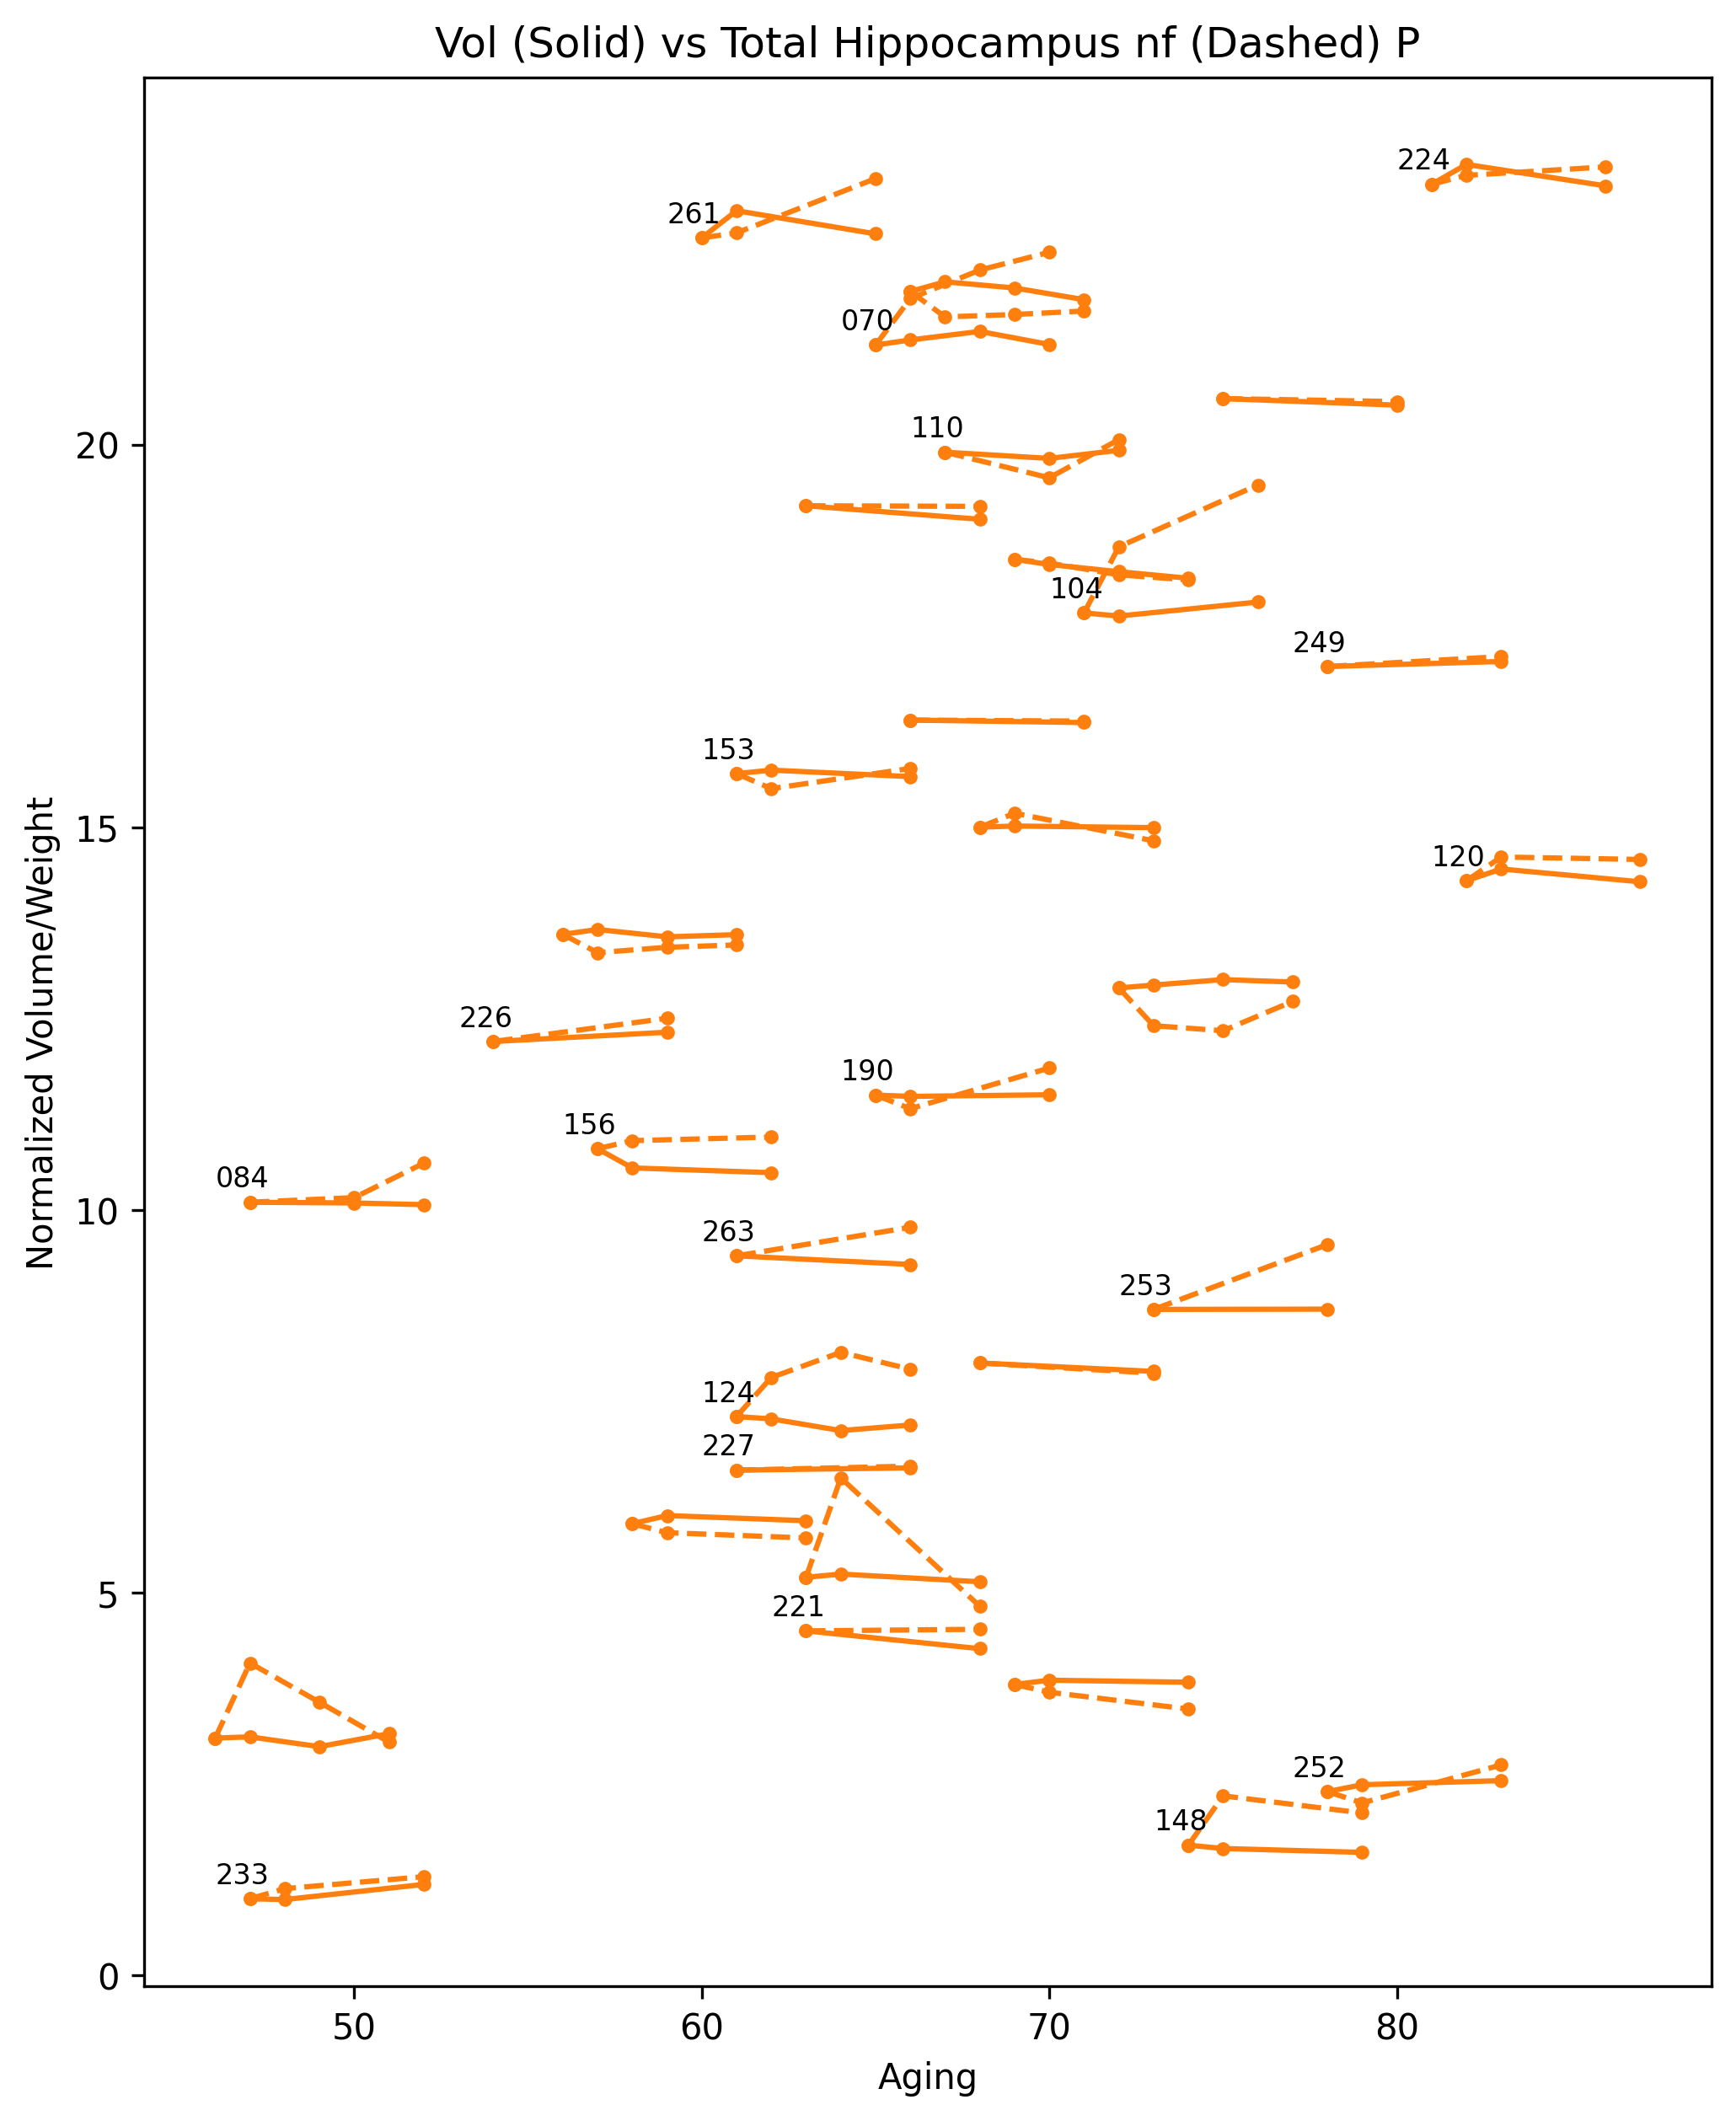

In [53]:
# metadata, node_list = prev_fct.load_meta_data()
roi = 'hippocampus'
plot_df = get_vol_nf_df(roi)
individual_scatter(plot_df[plot_df['C/T'] == 'HC'], ['vol', 'nf'], 'Vol (Solid) vs Total Hippocampus nf (Dashed) HC')
individual_scatter(plot_df[plot_df['C/T'] == 'P'], ['vol', 'nf'], 'Vol (Solid) vs Total Hippocampus nf (Dashed) P')

# Changes in rs-Networks across human lifespan, Betzel et al., 2014
- Paper shows that there's structural changes across lifespan. Two measures were defined for a coarse measure of change:
1. m: total number of edges (binary)
2. nf: total fibre count

They showed that when plotted against age, both exhibited statistically significant linear decrease with age.

Below is to try and reproduce these plots with our non-normalized connectomes. The same linear decrease should be found
across all time periods (BL, Y1, Y3, Y5).

In [76]:
import scipy.stats
def linear_model(data_df, xlabel, ylabel):
    # remove outliers (only from y axis)
    x = np.array(data_df[ylabel])
    # med = statistics.median(x)
    med = np.median(x)
    stddev = np.std(x)
    model_df = data_df[(data_df[ylabel] < med + 3*stddev) & (data_df[ylabel] > med - 3*stddev)]
    x_fit = np.array(model_df[xlabel])
    y_fit = np.array(model_df[ylabel])
    if len(x_fit) == 0 or len(y_fit) == 0:
        print(f"No data for {xlabel}, {ylabel}")
        return None
    slope, intercept, _, p, stderr = scipy.stats.linregress(x_fit,y_fit)
    return slope, intercept, p, stderr

def get_connectome_change_df():
    ids = []
    time = []
    age = []
    diagnosis = []
    # --- measures of change
    m = []
    nf = []
    for k in individual_data.keys():
        if len(k) == 4:
            ptype = k[:2]
            t = k[2:]
        else:
            ptype = k[0]
            t = k[1:]
        for pid, G in individual_data[k].items():
            diagnosis.append(ptype)
            ids.append(pid)
            time.append(t)
            age.append(metadata.loc[pid]['Age'])
            edges = nx.get_edge_attributes(G, "weight")
            m.append(len(edges))
            nf.append(sum([e2 for e1, e2 in edges.items()]))
    return pd.DataFrame(data = {'ID': ids, 'Age': age, 'Time': time, 'C/T': diagnosis, 'm': m, 'nf': nf})
connectome_change_df = get_connectome_change_df()

In [86]:
SAVE_FLAG = True
color_palette = {'HC': 'tab:blue', 'P': 'tab:orange'}
aged = {'bl': 0, 'y1': 1, 'y3': 3, 'y5': 5}
fig, axes = plt.subplots(1,4, figsize=(20, 6))
for ptype in ['HC', 'P']:
    data = connectome_change_df[(connectome_change_df['C/T']==ptype)]
    for i, time in enumerate(['bl', 'y1', 'y3', 'y5']):
        plot_data = data[data['Time']==time]
        # print(f"There are {len(plot_data.index)} {ptype} individuals @ {time}")
        slope, intercept, p, stderr = linear_model(plot_data, 'Age', 'm')
        axes[i].scatter(plot_data['Age'] + aged[time], plot_data['m'], facecolors='none', edgecolors = color_palette[ptype])
        xseq = np.linspace(min(plot_data['Age']), max(plot_data['Age']), 10)
        axes[i].plot(xseq, intercept + slope*xseq, color=color_palette[ptype], label=f"{ptype} (m = {slope:0.2f}, p = {p:0.3f})")
        axes[i].legend()
        axes[i].set_xlabel('Age')
        axes[i].set_title(time)
axes[0].set_ylabel("number of edges (m)")
fig.suptitle(f"Non-Normalized Connectomes")
if SAVE_FLAG:
    full_path = f'../../PREVENT_study/figures/'
    figName = full_path + f'Age vs m.png'
    if not os.path.exists(os.path.dirname(full_path)):
        os.makedirs(os.path.dirname(full_path))
    print("Saving...", figName)
    plt.savefig(figName, dpi=300, facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')
    plt.close(fig)
else:
    plt.show()

Saving... ../../PREVENT_study/figures/Age vs m.png
